In [1]:
from Funcoes import *
from tensorflow.keras.models import load_model

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['lines.linewidth'] = 2

In [4]:
model_2_sps = load_model('model_sps_2.h5')
model_4_sps = load_model('model_sps_4.h5')

In [16]:
M = 16        # ordem da modulação
Fb = 24e9      # taxa de símbolos
SpS = 4         # amostras por símbolo
Fs = SpS*Fb    # taxa de amostragem
rolloff = 0.05  # Rolloff do filtro formatador de pulso
amostras = 512
size = 120000

#def data_test_to_obtain_BERxSNR_plot(model,data,X):
#    X = MinMaxScaler().fit_transform(X)
#    predictions = model.predict(X)
#    predicted_signal = data['amplitudes']*np.exp(1j*predictions.reshape(-1,))
#    return predicted_signal.reshape((1,-1))

In [36]:
def KramersKronigRx(Amp, Nsamples, Fs):
    """
    :param Amp: signal amplitude value
    :param Nsamples: size of the FFT
    :param Fs: signal's sampling frequency
    :return phiTime: calculated signal's phase values
    """
    T  = 1/Fs 
    xf = np.fft.fftfreq(Nsamples, T)
    xf = np.fft.fftshift(xf)                
                       
    phiOmega = 1j*np.sign(xf)*np.fft.fft(np.log(Amp))
    
    phiTime  = np.fft.ifft(phiOmega)
    
    return np.real(phiTime)

In [9]:
SNRs = np.arange(16,40.1,0.5)
BERs = np.zeros(SNRs.size)
SpS = 4
if SpS == 4:
    model = model_4_sps
if SpS == 2:
    model = model_2_sps
for i , SNR in enumerate(SNRs):
    qam_signal = generate_signal(M,Fb,SpS,SNR,rolloff=0.05)
    sfm, A = qam_signal_phase_min(qam_signal)
    data,X,y = dataset_02(sfm,amostras,size)
    predicted_signal = data_test_to_obtain_BERxSNR_plot(model,data,X)
    reverted_signal = revert_sfm(predicted_signal,A)
    BERs[i] = reverted_signal[0,::SpS].cal_ber()

In [37]:
SNRs = np.arange(16,40.1,0.1)
BERsKK = np.zeros(SNRs.size)
for i , SNR in enumerate(SNRs):
    qam_signal = generate_signal(M,Fb,SpS,SNR,rolloff=0.05)
    sfm, A = qam_signal_phase_min(qam_signal,10)
    data,X,y = dataset_02(sfm,amostras,size)
    phases = KramersKronigRx(data['amplitudes'],size,Fs)
    predicted_kk_signal = data['amplitudes']*np.exp(1j*phases.reshape(-1,))
    reverted_signal = revert_sfm(predicted_kk_signal.reshape((1,-1)),A)
    BERsKK[i] = reverted_signal[0,3000:(size-3000):SpS].cal_ber()

In [17]:
SNRs = np.arange(16,40.1,0.1)
BERsAWGN = np.zeros(SNRs.size)
for i , SNR in enumerate(SNRs):
    qam_signal = generate_signal(M,Fb,SpS,SNR,rolloff=0.05)
    qam_signal_rx = normcenter(lowpassFilter(qam_signal, qam_signal.fs, 1/qam_signal.fb, 0.05, taps=4001))
    BERsAWGN[i] = qam_signal_rx[0,3000:(size-3000):SpS].cal_ber()


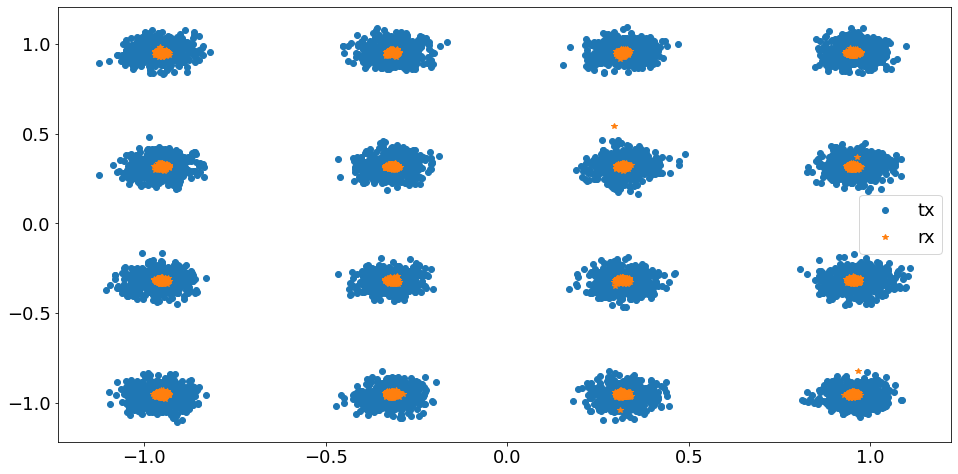

In [20]:
plt.plot(qam_signal.real[0,:30000:SpS],qam_signal.imag[0,:30000:SpS],'o')
plt.plot(qam_signal_rx.real[0,:30000:SpS],qam_signal_rx.imag[0,:30000:SpS],'*')
plt.legend(['tx','rx'])

In [13]:
help(normcenter)

Help on function normalise_and_center in module qampy.helpers:

normalise_and_center(E)
    Normalise and center the input field, by calculating the mean power for each polarisation separate and dividing by its square-root



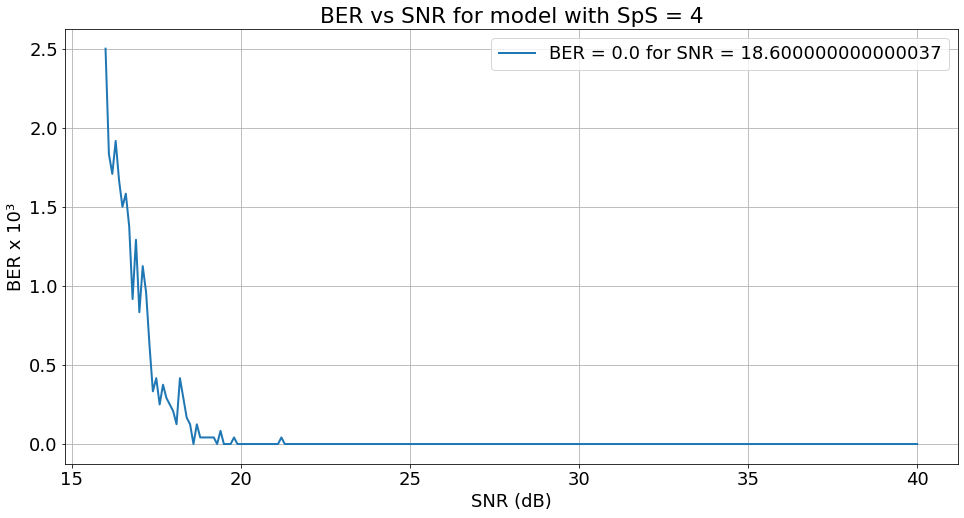

In [38]:
min_ber = np.argmin(BERsKK)
plt.plot(SNRs,BERsKK*1e3)
plt.title(f'BER vs SNR for model with SpS = {SpS}')
plt.xlabel('SNR (dB)')
plt.ylabel('BER x 10³')
plt.legend([f'BER = {BERsKK[min_ber]} for SNR = {SNRs[min_ber]}'])
plt.grid(True)
#plt.savefig(f'BER_x_SNR_model_{SpS}_SpS.png')
np.savetxt(f'SNR_BER_KK_model_{SpS}_sps.txt',[SNRs,BERsKK])

In [13]:
qam_signal = generate_signal(M,Fb,SpS,16,rolloff=0.05)
sfm, A = qam_signal_phase_min(qam_signal,10)
data,X,y = dataset_02(sfm,amostras,size)

In [14]:
data['amplitudes'].size

30000

In [15]:
phases = KramersKronigRx(data['amplitudes'],data['amplitudes'].size,Fs)

In [16]:
phases[:5]

array([ 0.11036993, -0.02162068, -0.04160197, -0.0380408 ,  0.09020235])

In [17]:
data['phases'][:5]

ResampledQAM([ 0.10153874, -0.00146035, -0.03194575, -0.01779038,
               0.0901295 ])

In [26]:
SpS = 4
SNRs, BERs = np.loadtxt(f'SNR_BER_model_{SpS}_sps.txt')

In [12]:
qam_signal = generate_signal(M,Fb,SpS,30,rolloff=0.05)
sfm, A = qam_signal_phase_min(qam_signal)
data,X,y = dataset_02(sfm,amostras,size)
preds = data_test_to_obtain_BERxSNR_plot(model_2_sps,data,X)

In [13]:
preds.shape

(50000,)

In [21]:
SpS = 4
SNRs, BERs = np.loadtxt(f'SNR_BER_model_{SpS}_sps.txt')
_, BERsKK = np.loadtxt(f'SNR_BER_KK_model_{SpS}_sps.txt')

<ipython-input-22-47c2e1e32ba5>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNRs,np.log10(BERs))
<ipython-input-22-47c2e1e32ba5>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNRs,np.log10(BERsAWGN))
<ipython-input-22-47c2e1e32ba5>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(SNRs,np.log10(ber_theory(helpers.dB2lin(SNRs), 16)),'--')


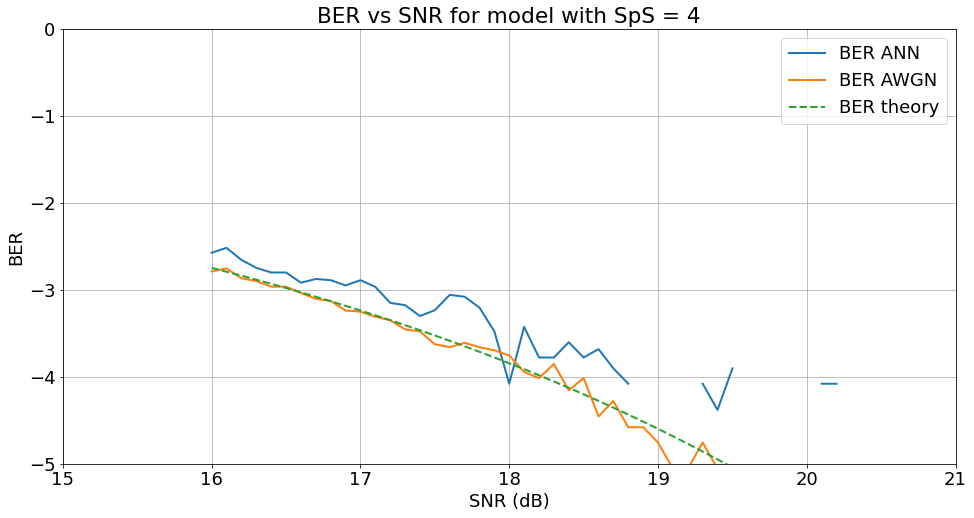

In [22]:
plt.plot(SNRs,np.log10(BERs))
plt.plot(SNRs,np.log10(BERsAWGN))
plt.plot(SNRs,np.log10(ber_theory(helpers.dB2lin(SNRs), 16)),'--')
plt.title(f'BER vs SNR for model with SpS = {SpS}')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.ylim([-5,0])
plt.xlim([15,21])
#plt.legend([f'BER = {BERsKK[min_ber]} for SNR = {SNRs[min_ber]}'])
plt.legend(['BER ANN', 'BER AWGN','BER theory'])
#plt.savefig(f'logBER_x_SNR_comparison_{SpS}_SpS.png')
plt.grid(True)

In [8]:
1/96000

1.0416666666666666e-05